# HW1-2: Optimization

In [ ]:
###############################################
#########    Deep Learning            #########
#########    Pedram MohajerAnsari     #########
#########    Homework 1 - Part 2      #########
###############################################

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cd drive/MyDrive/Deep_Learning_HW1/P1

In [10]:
############################################
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
TORCH_CUDA_ARCH_LIST="8.6"
############################################
import torch
import torchvision
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torch.backends.cudnn   as cudnn
import torchvision.transforms as transformtransforms
import torchvision.transforms.functional as TF
from   sklearn.decomposition import PCA
from   mpl_toolkits.mplot3d import Axes3D

############################################
from torchvision  import models
from torchsummary import summary
from torchvision  import transforms
############################################
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
from tqdm import tqdm
############################################
import cv2
import copy
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image
from   glob import glob
############################################

In [ ]:
############################################
Project_PATH = os.path.dirname(os.path.abspath('__file__'))
outputs_dir = Project_PATH + '/'
model_path  = Project_PATH + '/save_models/'
############################################

In [11]:
############################################
print('Is CUDA available : ',torch.cuda.is_available())
############################################
print('Device Count      : ',torch.cuda.device_count())
############################################
print('Currrent Device   : ',torch.cuda.current_device())
############################################
device_default = torch.cuda.current_device()
torch.cuda.device(device_default)
print('Default Device    : ',torch.cuda.get_device_name(device_default))
############################################
device = torch.device("cuda")
print('Cude Version      : ',torch.version.cuda)
############################################
print('Torch Version     : ',torch.__version__)
############################################
print(torch.cuda.get_arch_list())
############################################

Is CUDA available :  True
Device Count      :  1
Currrent Device   :  0
Default Device    :  Tesla T4
Cude Version      :  11.6
Torch Version     :  1.13.1+cu116
['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']


## HW1-2 Visualize the Optimization Process

In [13]:
##########################################################################################

class MODEL_MNIST(nn.Module):
    def __init__(self):
        super(MODEL_MNIST, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(28*28, 32),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(32, 16),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(16, 10))
    
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x)    
        return x
    
device            = torch.device("cuda")
Model_MODEL_MNIST = MODEL_MNIST().to(device)
summary( Model_MODEL_MNIST, input_size=(1,28*28))

##########################################################################################

class CNN_CIFAR_6_layer(nn.Module):
    def __init__(self):
        super(CNN_CIFAR_6_layer, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 10, 3),   nn.BatchNorm2d(10),nn.ReLU(True), nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        self.layer2 = nn.Sequential( nn.Conv2d(10, 16, 3),  nn.BatchNorm2d(16),nn.ReLU(True), nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        self.layer3 = nn.Sequential( nn.Conv2d(16, 32, 3),  nn.BatchNorm2d(32),nn.ReLU(True))
        self.layer4 = nn.Sequential( nn.Linear(32*4*4, 64), nn.BatchNorm1d(64),nn.ReLU(True))
        self.layer5 = nn.Sequential( nn.Linear(64, 16),     nn.BatchNorm1d(16),nn.ReLU(True))
        self.layer6 = nn.Sequential( nn.Linear(16, 10))
    
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x) 
        x = x.view(x.size()[0], -1)
        x = self.layer4(x)    
        x = self.layer5(x)    
        x = self.layer6(x)    
        return x
    
device = torch.device("cuda")
Model  = CNN_CIFAR_6_layer().to(device)
summary( Model, input_size=(3,32,32) )


##########################################################################################

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]          25,120
              ReLU-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 16]             528
              ReLU-4                [-1, 1, 16]               0
            Linear-5                [-1, 1, 10]             170
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 30, 30]             280
       BatchNorm2d-2           [-1, 10, 30,

In [14]:
##########################################################################################

def train(modelName, Epochs=20, Batch=2000, Data_workers=0, LR=0.1):



    "LOADING DATA"
    trainset    = torchvision.datasets.MNIST(root='./data/', train=True,   download=True, transform=transforms.ToTensor())
    testset     = torchvision.datasets.MNIST(root='./data/', train=False,  download=True, transform=transforms.ToTensor())
    trainloader = DataLoader(trainset, batch_size=Batch,     shuffle=True, num_workers=Data_workers)
    testloader  = DataLoader(testset,  batch_size=Batch,     shuffle=True, num_workers=Data_workers)


    print("DATASET INFORMATION : ")
    print(trainset.classes)
    print(trainset.data.shape)
    print(testset.data.shape)
    print('################################')

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    Model = modelName().to(device)

    number_of_param = sum(param.numel() for param in Model.parameters())
    print('Number of total parameters: ', number_of_param)

    #### loss & optimizer ####
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(Model.parameters(), lr=LR, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.8)
    
    ### Training ####
    
    trainloss_list = []
    testloss_list  = []
    accuracy_list  = []
    
    w         = []
    w_1       = []
    w_loss    = []
    lr_list   = []
    grad_list = []


    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        for i, data in enumerate(trainloader):
            images, labels = data
            images  = (images.view(-1, 28*28)).to(device)
            labels  = labels.to(device)
            outputs = Model(images)
            loss    = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        #### Evaluating ####
      
        Model.eval()
        with torch.no_grad():
            test_loss = 0
            correct   = 0
            total     = 0
            for data in testloader:
                images, labels = data
                images  = (images.view(-1, 28*28)).to(device)
                labels  = labels.to(device)
                outputs = Model(images)
                loss    = criterion(outputs, labels)
                test_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                correct += (pred == labels).cpu().sum()
            total    = len(testloader.dataset)
            accuracy = 100.0*correct/total

        #### Save loss ####

        lr_list.append( optimizer.state_dict()['param_groups'][0]['lr'] )
        trainloss_list.append(train_loss)
        testloss_list.append(test_loss)
        accuracy_list.append(accuracy)
        
        print('{}/{} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(epoch, Epochs,test_loss, correct, total, accuracy))
 
        #### Weight collect ####

        if epoch % 1 == 0:
            #### Layer weights ####
            weights_layer = np.zeros(0)
            for name,parameters in Model.named_parameters():
                if name == 'layer2.0.weight':
                    weight_i      = (parameters.detach().cpu().numpy().reshape(-1))
                    weights_layer = np.concatenate((weights_layer, weight_i))
                    break
            print(weights_layer.shape)
            w_1.append(weights_layer)
            
            weights = np.zeros(0)
            for name,parameters in Model.named_parameters():
                if name[-6:] == 'weight':
                    weight_i = (parameters.detach().cpu().numpy().reshape(-1))
                    weights  = np.concatenate((weights, weight_i))
            print(weights.shape)
            w.append(weights)
            w_loss.append(train_loss)
        
        #### Grad collect ####

        grad_all = 0.0

        for p in Model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_list.append(grad_all**0.5)
        
    return [trainloss_list, testloss_list, accuracy_list, lr_list, w, w_1, w_loss, grad_list]
    


### Collect weights of the model

In [15]:
##################################################################

events = 8
W      = []
W_loss = []
W_1    = []
G      = []

for i in range(events):
    print('Event : ' +str(i+1) )
    [_, _ ,_ ,_ ,w ,w_1 ,w_loss , grad_list] = train(MODEL_MNIST)
    W.append(w)
    W_1.append(w_1)
    W_loss.append(w_loss)
    G.append(grad_list)
    
##################################################################

Event : 1
DATASET INFORMATION : 
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
################################
Number of total parameters:  25818
0/20 Test set: Average loss: 3.7212, Accuracy: 7635/10000 (76.35%)
(512,)
(25760,)
1/20 Test set: Average loss: 1.9617, Accuracy: 8841/10000 (88.41%)
(512,)
(25760,)
2/20 Test set: Average loss: 1.5499, Accuracy: 9071/10000 (90.71%)
(512,)
(25760,)
3/20 Test set: Average loss: 1.3142, Accuracy: 9228/10000 (92.28%)
(512,)
(25760,)
4/20 Test set: Average loss: 1.1868, Accuracy: 9287/10000 (92.87%)
(512,)
(25760,)
5/20 Test set: Average loss: 1.0634, Accuracy: 9367/10000 (93.67%)
(512,)
(25760,)
6/20 Test set: Average loss: 1.0227, Accuracy: 9407/10000 (94.07%)
(512,)
(25760,)
7/20 Test set: Average loss: 0.8720, Accuracy: 9491/10000 (94.91%)
(512,)
(25760,)
8/20 Test set: Average loss: 0.8395, Accuracy: 9493/10000 

### PCA reduce dimention to 2

In [22]:
def W_2(W_input):
    w   = np.array(W_input)
    pca = PCA(n_components=2)
    pca.fit(w)
    w_new = pca.transform(w)
    return w_new

##################################################################

W_pca = []

for i in range(events):
    w_pca = W_2(W[i])
    W_pca.append(w_pca)

W_pca = np.array(W_pca)

##################################################################

W_1_pca = []

for i in range(events):
    w_1_pca = W_2( W_1[i] )
    W_1_pca.append( w_1_pca )

W_1_pca = np.array( W_1_pca )


# Plotting weight

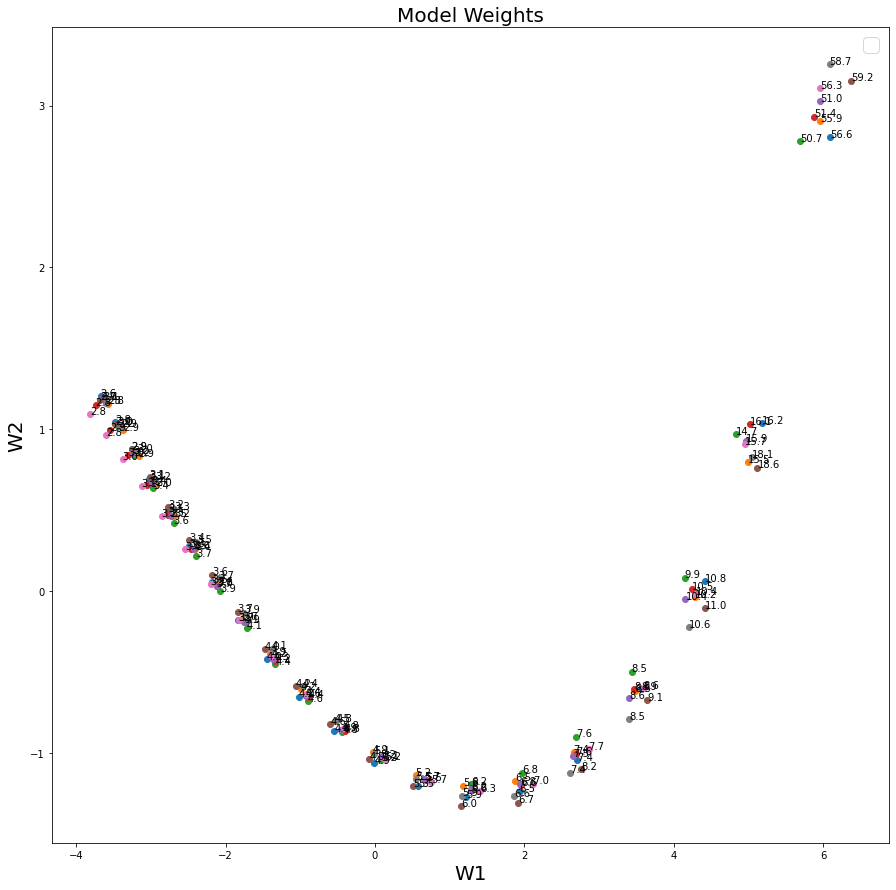

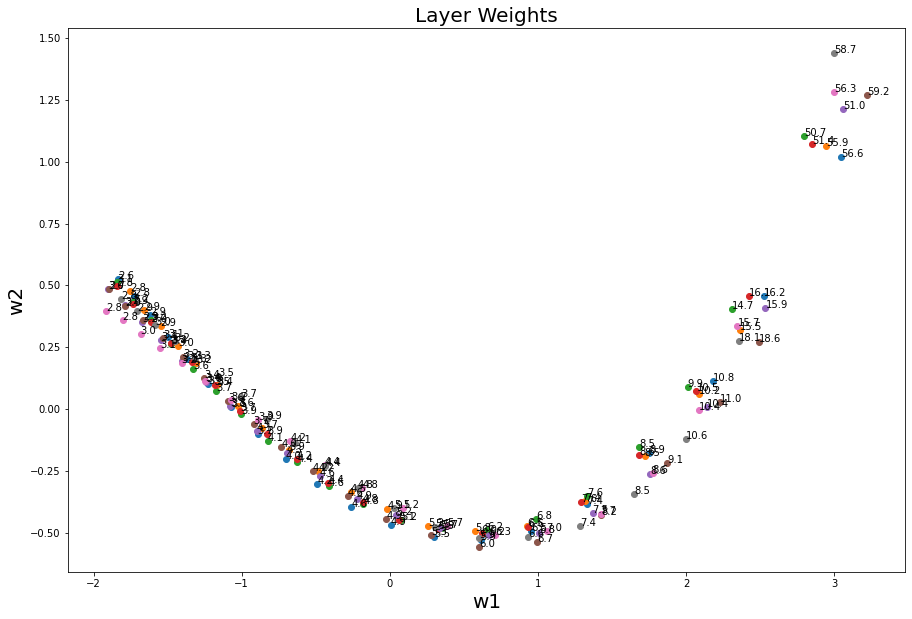

In [23]:
def plotting():

  plt.figure(figsize=(15,15))
  plt.xlabel('W1',fontsize=20)
  plt.ylabel('W2',fontsize=20)
  plt.title('Model Weights',fontsize=20)
  plt.legend(fontsize=20)

  for i in range(events):
      W_i = W_pca[i]
      plt.scatter(W_i[:,0], W_i[:,1])
      for j in range(len(W_i)):
          plt.annotate(round(W_loss[i][j],1), (W_i[j,0],W_i[j,1]))

  plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_2/img0.png')
  plt.show()

  plt.figure(figsize=(15,10))
  plt.xlabel('w1',fontsize=20)
  plt.ylabel('w2',fontsize=20)
  plt.title('Layer Weights',fontsize=20)

  for i in range(events):
      W_i = W_1_pca[i]
      plt.scatter(W_i[:,0], W_i[:,1])
      for j in range(len(W_i)):
          plt.annotate(round(W_loss[i][j],1), (W_i[j,0],W_i[j,1]))
  plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_2/img1.png')
  plt.show()

##################################################################
plotting()

## Visualizing Error Surface

<ipython-input-24-3c67ce28936d>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zx = ( (Error[i,0]) * 10).astype(np.int)
<ipython-input-24-3c67ce28936d>:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

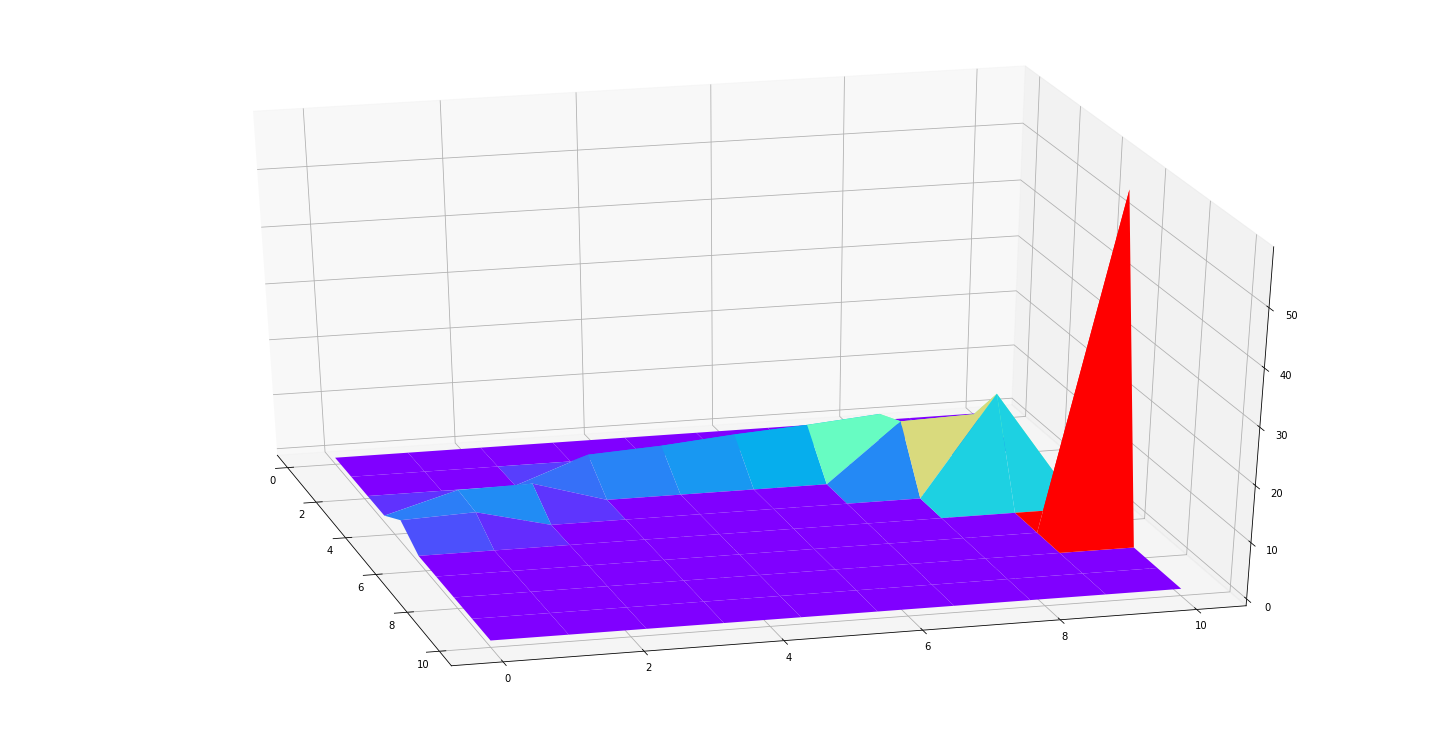

In [24]:
from   mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(20,10))
ax  = Axes3D(fig)

########

W_all      = W_pca.reshape( (events*len(W_pca[0]), 2))
W_loss_collected = np.array(W_loss)
W_loss_collected = W_loss_collected.reshape(-1)

########

x    = np.linspace(0,10,10)
y    = np.linspace(0,10,10)
X, Y = np.meshgrid(x, y)
z    = X-X

########

Error = ( W_all-np.min(W_all) ) / (np.max(W_all) - np.min(W_all))
Error[Error==1] = 0.99

########

for i in range(len(Error[:,0])):
    zx = ( (Error[i,0]) * 10).astype(np.int)
    zy = ( (Error[i,1]) * 10).astype(np.int)
    z[zx,zy] = W_loss_collected[i]


ax.plot_surface(X, Y, z, cmap='rainbow')
ax.view_init(elev=30, azim=-15)
plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_2/img3.png')
plt.show()
    

## Observing Gradient Norm During Training

In [25]:
class MODEL_MNIST_3_Layer(nn.Module):
    
    def __init__(self):
        super(MODEL_MNIST_3_Layer, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(1, 32),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(32, 16),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(16, 1))
    
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x)    
        return x

##################################################################

device = torch.device("cuda")
Model  = MODEL_MNIST_3_Layer().to(device)
summary(Model, (1,1))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]              64
              ReLU-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 16]             528
              ReLU-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 1]              17
Total params: 609
Trainable params: 609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [32]:
#### Initiate data ####

x = torch.linspace(0,1,1000).unsqueeze(1)
y = torch.sin(5*np.pi*x)/(5*np.pi*x)

y[0]   = y[1]
func_sign = y

#### Define train function ####

def train(function, model_name, Epochs = 20000, Batch  = 1000, Data_workers = 0, LR = 0.0005):
    
    #### Initiate Model ####
  
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
    Model  = model_name().to(device)
    x = torch.linspace(0,1,1000).unsqueeze(1)
    x = x.to(device)
    y = function.to(device)

    #### loss function & optimizer ####

    criterion = nn.MSELoss()
    optimizer = optim.Adam( Model.parameters(), lr = LR)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.8)

    #### Training Mode ####

    trainloss_list = []
    lr_list        = []
    grad_list      = []

    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        y_pred     = Model(x)
        loss       = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        trainloss_list.append(train_loss)

        if epoch % (Epochs//10) == 0:
            print('{}/{}, loss: {}'.format(epoch,Epochs,train_loss))
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        
        #### Collecting Grad ####
        
        grad_all = 0.0
        for p in Model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_list.append(grad_all**0.5)
            
    return [Model, trainloss_list, lr_list,grad_list]



In [33]:
[ Model, trainloss, lr, grad_list ] = train(func_sign, MODEL_MNIST_3_Layer, Epochs=20000, Batch=1000, Data_workers=0, LR=0.005)

0/20000, loss: 0.08943444490432739
2000/20000, loss: 8.81283194757998e-05
4000/20000, loss: 3.352143176016398e-05
6000/20000, loss: 5.6487551773898304e-05
8000/20000, loss: 1.5542542314506136e-05
10000/20000, loss: 1.2597603927133605e-05
12000/20000, loss: 1.174851513496833e-05
14000/20000, loss: 1.119829812523676e-05
16000/20000, loss: 1.6107327610370703e-05
18000/20000, loss: 1.0726420441642404e-05


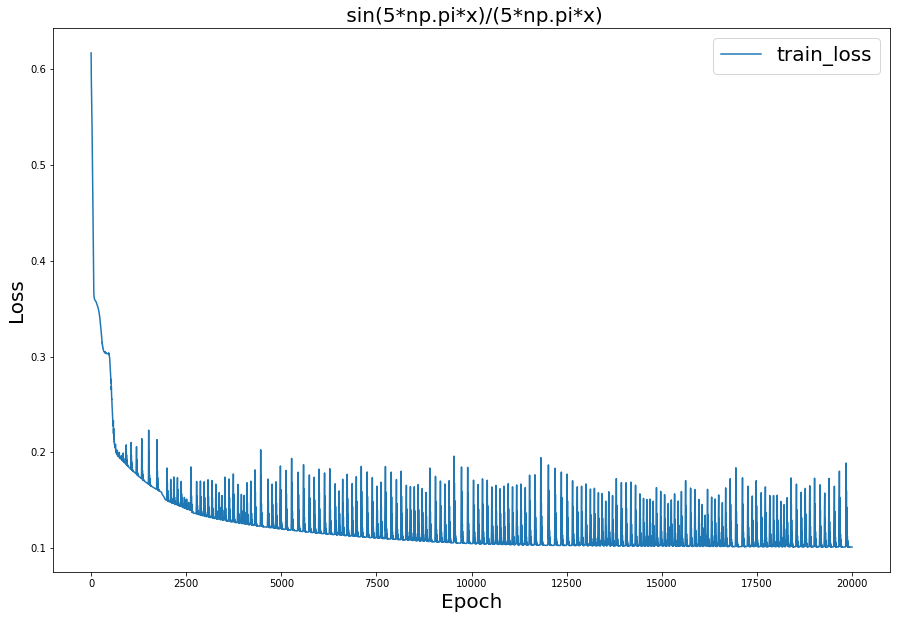

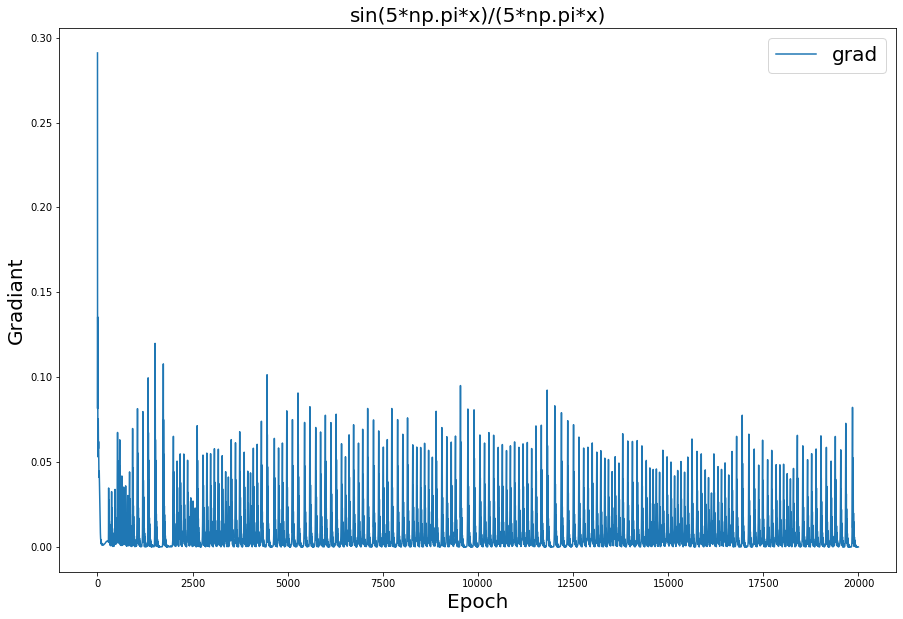

In [34]:
############################################################
plt.figure(figsize=(15,10))
plt.plot(np.array(trainloss)**0.2, label='train_loss')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss' ,fontsize=20)
plt.title(' sin(5*np.pi*x)/(5*np.pi*x)',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_2/img4.png')
plt.show()
############################################################
plt.figure(figsize=(15,10))
plt.plot(np.array(grad_list)**1, label='grad')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Gradiant', fontsize=20)
plt.title('sin(5*np.pi*x)/(5*np.pi*x)',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_2/img5.png')
plt.show()
############################################################